**Install Dependencies**

In [1]:
# %%capture
# !pip install -U torch torchvision torchaudio torcheval
# !pip install -U triton xformers
# !pip install -U diffusers transformers accelerate jupyter huggingface-hub bitsandbytes tqdm;
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_diffusers_utils

**Check diffusers version**

In [2]:
# Import the `diffusers` module
import diffusers

# Print the version number of the `diffusers` module
print(diffusers.__version__)

0.12.1


**Import Dependencies**

In [3]:
# Import necessary modules from the standard library
from pathlib import Path  # For working with file paths
import hashlib  # For generating hash values
import json  # For working with JSON data
import random  # For generating random numbers
import math

from PIL import Image  # For working with images

import numpy as np  # For working with arrays

import torch  # PyTorch module for deep learning
from torchvision import transforms  # PyTorch module for image transformations

# Import diffusers pipeline and noise schedulers
from diffusers import StableDiffusionPipeline
from diffusers import DEISMultistepScheduler

# Import tqdm module for progress bars
from tqdm.auto import tqdm

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

In [4]:
from cjm_diffusers_utils.core import *
from cjm_pil_utils.core import stack_imgs, get_img_files
from cjm_pytorch_utils.core import get_torch_device

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [5]:
# Import the notebook_login function from the huggingface_hub module
from huggingface_hub import notebook_login

# If the user does not have a an access token saved, prompt them to log in
if not (Path.home()/'.huggingface'/'token').exists():
    notebook_login()

**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML Open RAIL++-M License](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* [**Stable Diffusion v2-1 Base Model Card**](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [**Stable Diffusion v2-1 Model Card**](https://huggingface.co/stabilityai/stable-diffusion-2-1)

**Select a model**

In [6]:
# model_name = "stabilityai/stable-diffusion-2-1-base"
# model_name = "stabilityai/stable-diffusion-2-1"

In [7]:
model_name = "./dreambooth_checkpoints/cp2077-steelbook-768"

**Set device and data type**

In [8]:
device = get_torch_device()
dtype = torch.float16 if device == 'cuda' else torch.float32
device, dtype

('cuda', torch.float16)

**Define a Stable Diffusion Image-to-Image pipeline**

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=dtype).to(device)

/home/innom-dt/mambaforge/envs/sd-testing/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [10]:
unet = pipe.unet
vae = pipe.vae

In [11]:
# Try to use xFormers for memory efficient attention
try:
    unet.enable_xformers_memory_efficient_attention()

# If an exception is raised, print a message indicating that it was unable to use the xformers
except:
    print("Unable to use xformers.")

In [12]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

**Define directory to store generated images**

In [13]:
output_dir = Path("./output_dir/text2img/")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

PosixPath('output_dir/text2img')

**Define method to save image with unique file name**

In [14]:
def save_img(image, save_dir, fmt='PNG'):
    # Calculate the SHA256 hash of the image
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]

    # Save the image to the specified directory with the hash as the file name
    image.save(f"{save_dir}/{img_hash}.{fmt.lower()}", format=fmt)

    # Return the image hash
    return img_hash

**Define method to pipeline config used to generate an image**

In [15]:
def save_pipe_config(img_name, pipe_config, save_dir):
    # Save the pipe configuration to a JSON file with the given image name
    with open(f"{save_dir}/{img_name}.json", "w") as write_file:
        json.dump(pipe_config, write_file)

In [16]:
def denoise_text2img(latents, text_emb, unet, noise_scheduler, guidance_scale=8.0):
        
    """
    Generate an image from a given prompt.
    
    Parameters:
    """
    
    # Denoising loop
    for i,ts in enumerate(tqdm(noise_scheduler.timesteps)):
        
        # Scale latents
        inp = noise_scheduler.scale_model_input(torch.cat([latents] * 2), ts)
              
        # Get model output
        with torch.no_grad(): 
            noise_pred_uncond, noise_pred_text = unet(inp, ts, encoder_hidden_states=text_emb).sample.chunk(2)
        
        g_current = guidance_scale
        
        # Apply guidance
        noise_pred = noise_pred_uncond + g_current*(noise_pred_text-noise_pred_uncond)
        
        # Update latents
        latents = noise_scheduler.step(noise_pred, ts, latents).prev_sample
        
        # Releases all unoccupied cached memory
        if unet.device.type == 'cuda': torch.cuda.empty_cache()
    
    return latents

In [17]:
src_prompt = "a puppy"
src_prompt

'a puppy'

In [18]:
new_token = None
if len(tokenizer.added_tokens_encoder.keys()) > 0:
    new_token = list(tokenizer.added_tokens_encoder.keys())[0]
new_token

'<cp2077-steelbook>'

In [19]:
style_weight = math.ceil(len(tokenizer.tokenize(src_prompt))//2)
style_weight

1

In [20]:
# style_prompt = ', '.join([f'monet oil painting']*(style_weight))
style_prompt = ', '.join([f'{new_token} style']*(style_weight))

In [21]:
prompt = f"{style_prompt}, {src_prompt}"
prompt

'<cp2077-steelbook> style, a puppy'

**Define negative prompt**

In [22]:
negative_prompt = "bad, deformed, ugly, bad anotomy"
# negative_prompt = ""
negative_prompt

'bad, deformed, ugly, bad anotomy'

**Initialize random number generator for consistent images**

In [23]:
generator = torch.Generator(device=device)
# generator.manual_seed(1);
# generator.manual_seed(100);
generator.manual_seed(789890158);

In [24]:
infer_scheduler = DEISMultistepScheduler.from_pretrained(model_name, subfolder="scheduler")
# infer_scheduler = pipe.scheduler

In [25]:
pipe_config = {}
pipe_config['model'] = model_name
pipe_config['prompt'] = prompt
pipe_config['negative_prompt'] = negative_prompt
pipe_config['height'] = 768
pipe_config['width'] = 768
pipe_config['strength'] = 1.0
pipe_config['steps'] = 25
pipe_config['guidance'] = 8.0
pipe_config['init_seed'] = generator.initial_seed()
pipe_config['generator_state'] = [int(i) for i in generator.get_state()]
pipe_config['eta'] = 0.0
pd.DataFrame.from_dict(pipe_config, orient='index')

0
model                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ./dreambooth_checkpoints/cp2077-steelbook-768
prompt                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   <cp2077-steelbook> style, a puppy
negative_prompt                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           bad, deformed, ugly, bad anotomy
height                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 768
width                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  768
strength                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               1.0
steps                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   25
guidance                                                                                                                                                                                                                                                                                                                                         

  0%|          | 0/25 [00:00<?, ?it/s]

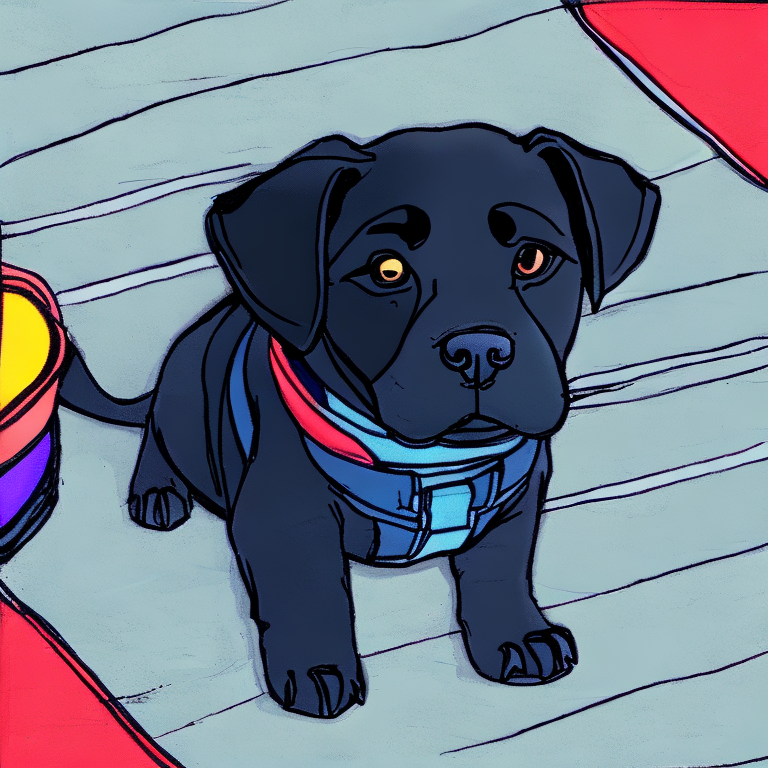

In [26]:
noise_scheduler = prepare_noise_scheduler(infer_scheduler, pipe_config['steps'], pipe_config['strength'])

# Convert the initial image to latent space
latents_shape = (1, unet.in_channels, pipe_config['height']//8, pipe_config['width']//8)
img_latents = torch.randn(latents_shape, device=unet.device, dtype=unet.dtype)

# Encode the prompt and negative prompt using the tokenizer and text_encoder
text_emb = text_to_emb(prompt=pipe_config['prompt'], 
                       tokenizer=tokenizer, 
                       text_encoder=text_encoder, 
                       negative_prompt=pipe_config['negative_prompt'])

# Specify number of images to generate
num_images = 1
all_images = []
generator_states = []

for i in range(num_images):

    # Generate latent noise
    noise = torch.randn(img_latents.shape, generator=generator, device=unet.device, dtype=unet.dtype)

    # Add noise to the image latents at the first timestep
    latents = noise_scheduler.add_noise(img_latents, noise, noise_scheduler.timesteps[[0]]).to(unet.device)

    denoised_latents = denoise_text2img(latents=latents,
                                        text_emb=text_emb,
                                        unet=unet,
                                        noise_scheduler=noise_scheduler,
                                        guidance_scale=pipe_config['guidance'])

    # Decode output tensors
    generator_states.append([int(i) for i in generator.get_state()])
    all_images.append(latent_to_pil(denoised_latents, vae))
    if device == 'cuda': torch.cuda.empty_cache()

for i, image in enumerate(all_images):
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]
    with open(f"{output_dir}/{img_hash}.json", "w") as write_file:
        json.dump(pipe_config, write_file)
    image.save(f"{output_dir}/{img_hash}.png", format='PNG')
    pipe_config['generator_state'] = generator_states[i]

stack_imgs(all_images)